In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# File paths
CSV_PATH = "FEVS_2024_PRDF.csv"
CODEBOOK_PATH = "2024_OPM_FEVS_PRDF_Codebook.xlsx"

# Load data
df = pd.read_csv(CSV_PATH, low_memory=False)
print(df.shape)
df.head()


(674207, 96)


,RandomID,POSTWT,agency,level1,Q1,Q2,Q3,Q4,Q5,Q6,...,Q91,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING
0,112970976817,1.597695,XX,XXZZ,3.0,4.0,4.0,4.0,1.0,NaN,...,2.0,B,B,B,B,B,B,A,B,D
1,194868625278,1.828360,XX,XXZZ,3.0,3.0,4.0,4.0,4.0,4.0,...,3.0,B,B,B,B,B,B,A,A,A
2,152966380283,1.867398,XX,XXZZ,2.0,1.0,3.0,3.0,3.0,2.0,...,3.0,B,B,B,B,A,A,A,A,A
3,193041162980,2.077359,XX,XXZZ,4.0,5.0,5.0,5.0,2.0,5.0,...,2.0,B,B,B,B,A,A,A,A,A
4,146655962451,1.494947,XX,XXZZ,4.0,4.0,4.0,4.0,4.0,4.0,...,3.0,B,B,A,B,B,C,A,A,A


In [10]:
# Load the codebook and pull in all sheets so I can see what I'm working with
xl = pd.ExcelFile(CODEBOOK_PATH)
sheets = {name: xl.parse(name) for name in xl.sheet_names}

# Quick scan of each sheet just to understand the structure
for name, d in sheets.items():
    print("\n---", name, "---")
    print(d.shape)
    display(d.head(3))


# Helper to clean up column names for easier comparison across sheets
def _norm_cols(d):
    d = d.copy()
    d.columns = [str(c).strip().lower() for c in d.columns]
    return d


# Rough check to see which sheet looks most like a question dictionary
# (this is exploratory - not the final join logic)
candidates = []

for name, d in sheets.items():
    dd = _norm_cols(d)
    cols = set(dd.columns)

    score = sum(
        k in cols
        for k in ["variable", "var", "item", "question", "label", "text", "description"]
    )

    candidates.append((score, name))

candidates = sorted(candidates, reverse=True)
print("Likely dictionary sheets:", candidates[:5])

# Use the top match for a quick look
best_sheet = candidates[0][1]
codebook_df = _norm_cols(sheets[best_sheet])

print("Using sheet:", best_sheet)
display(codebook_df.head())




--- Survey Items ---
(430, 7)


,VARIABLE,ITEM TEXT,RESPONSE VALUE,RESPONSE CHOICES,INDEX,PERFORMANCE DIMENSION,SPECIAL NOTES
0,Q1,I am given a real opportunity to improve my sk...,5,Strongly Agree,NaN,Performance Dimension: Employee-Focused - Empl...,NaN
1,Q1,I am given a real opportunity to improve my sk...,4,Agree,NaN,Performance Dimension: Employee-Focused - Empl...,NaN
2,Q1,I am given a real opportunity to improve my sk...,3,Neither Agree nor Disagree,NaN,Performance Dimension: Employee-Focused - Empl...,NaN



--- Demographics ---
(23, 5)


,VARIABLE,ITEM TEXT,RESPONSE VALUE,RESPONSE CHOICES,HEADERS AND NOTES
0,DRNO,Please select the racial category or categorie...,A,Black or African American,NaN
1,DRNO,Please select the racial category or categorie...,B,White,NaN
2,DRNO,Please select the racial category or categorie...,C,Asian,NaN



--- Agency Variable ---
(36, 2)


,CODE,NAME
0,AF,United States Department of the Air Force
1,AG,Department of Agriculture
2,AM,U.S. Agency for International Development



--- LEVEL1 Variable ---
(163, 2)


,CODE,NAME
0,AF0J,AIR EDUCATION AND TRAINING COMMAND
1,AF0M,AF RESERVE COMMAND
2,AF1C,AIR COMBAT COMMAND



--- Other Variables ---
(2, 2)


,VARIABLE,DESCRIPTION
0,RandomID,Randomly Assigned Number for individual cases
1,POSTWT,Weighting variable


Likely dictionary sheets: [(2, 'Other Variables'), (1, 'Survey Items'), (1, 'Demographics'), (0, 'LEVEL1 Variable'), (0, 'Agency Variable')]
Using sheet: Other Variables


,variable,description
0,RandomID,Randomly Assigned Number for individual cases
1,POSTWT,Weighting variable


In [11]:
# Reload the codebook since this is where the final dictionary is built
xl = pd.ExcelFile(CODEBOOK_PATH)


# Small helper to pull just the variable name and label from a given sheet
def load_var_label(sheet_name: str, var_col="VARIABLE", label_col="ITEM TEXT"):
    d = xl.parse(sheet_name)
    d = d.rename(columns={var_col: "variable", label_col: "label"})
    d["variable"] = d["variable"].astype(str).str.strip()
    d["label"] = d["label"].astype(str).str.strip()
    return d[["variable", "label"]].dropna().drop_duplicates()


# Pull question text for the main survey items
survey_dict = load_var_label("Survey Items", var_col="VARIABLE", label_col="ITEM TEXT")

# Pull labels for demographic variables
demo_dict = load_var_label("Demographics", var_col="VARIABLE", label_col="ITEM TEXT")


# Other Variables is formatted slightly differently, so handle it separately
other = xl.parse("Other Variables").rename(
    columns={"VARIABLE": "variable", "DESCRIPTION": "label"}
)
other["variable"] = other["variable"].astype(str).str.strip()
other["label"] = other["label"].astype(str).str.strip()
other_dict = other[["variable", "label"]].dropna().drop_duplicates()


# Combine everything into a single lookup table
data_dict = pd.concat([survey_dict, demo_dict, other_dict], ignore_index=True)

# Survey Items repeats variables for each response option,
# so keep one clean label per variable
data_dict = data_dict.drop_duplicates(subset=["variable"], keep="first")

print("Dictionary rows:", data_dict.shape)
data_dict.head(10)



Dictionary rows: (94, 2)


,variable,label
0,Q1,I am given a real opportunity to improve my sk...
1,Q2,I feel encouraged to come up with new and bett...
2,Q3,My work gives me a feeling of personal accompl...
3,Q4,I know what is expected of me on the job.
4,Q5,My workload is reasonable.
5,Q6,My talents are used well in the workplace.
6,Q7,I know how my work relates to the agency's goals.
7,Q8,I can disclose a suspected violation of any la...
8,Q9,I have enough information to do my job well.
9,Q10,I receive the training I need to do my job well.


In [12]:
# df is your survey response dataframe
col_df = pd.DataFrame({"variable": df.columns.astype(str).str.strip()})

col_map = col_df.merge(data_dict, on="variable", how="left")
match_rate = col_map["label"].notna().mean()

print(f"Matched labels for {match_rate:.1%} of columns")
col_map.head(25)


Matched labels for 97.9% of columns


,variable,label
0,RandomID,Randomly Assigned Number for individual cases
1,POSTWT,Weighting variable
2,agency,NaN
3,level1,NaN
4,Q1,I am given a real opportunity to improve my sk...
5,Q2,I feel encouraged to come up with new and bett...
6,Q3,My work gives me a feeling of personal accompl...
7,Q4,I know what is expected of me on the job.
8,Q5,My workload is reasonable.
9,Q6,My talents are used well in the workplace.


### 1. Data base Overview

Exploratory analysis began with a review of dataset structure, variable types, and missingness. Most survey items had high response rates, with missing values primarily concentrated in demographic or optional items.

In [14]:
df.shape

(674207, 96)

In [15]:
df.dtypes.value_counts()


object     51
float64    44
int64       1
Name: count, dtype: int64

In [16]:
df.isna().mean().sort_values(ascending=False).head(15)

DSEX        0.219832
DRNO        0.207715
DHISP       0.130423
DAGEGRP     0.120024
DDIS        0.106596
DMIL        0.068019
DSUPER      0.067945
DFEDTEN     0.067583
DLEAVING    0.062160
Q40         0.045452
Q87         0.044559
Q89         0.043461
Q86         0.043187
Q88         0.041339
Q70         0.041029
dtype: float64

### 2. Intent to leave

Responses to the intent-to-leave item showed meaningful variation across categories, indicating that a non-trivial portion of employees expressed some likelihood of leaving, supporting its use as the primary outcome variable.

In [48]:
# Distribution of intent to leave

counts = df["DLEAVING"].value_counts().sort_index()
total = counts.sum()

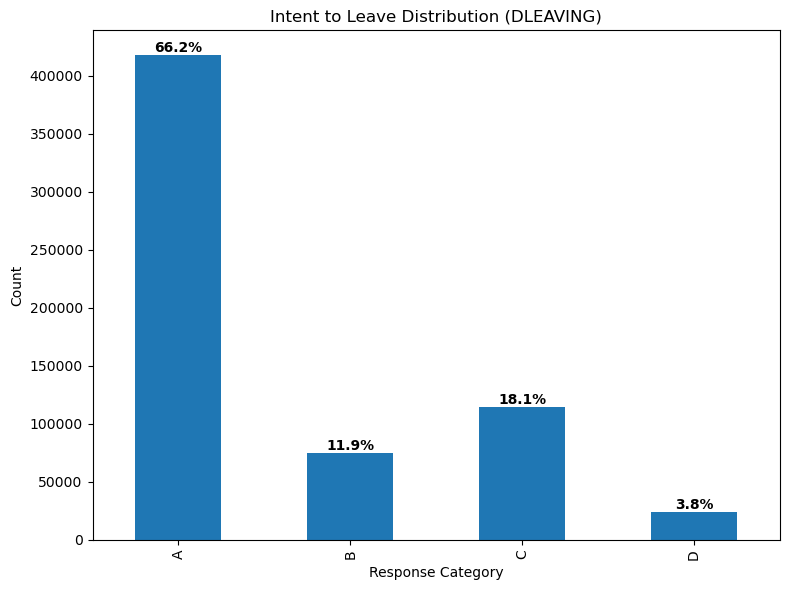

In [50]:
plt.figure(figsize=(8, 6))
ax = counts.plot(kind="bar")
plt.title("Intent to Leave Distribution (DLEAVING)")
plt.xlabel("Response Category")
plt.ylabel("Count")

# Add percentages on top of each bar
for i, (category, count) in enumerate(counts.items()):
    percentage = (count / total) * 100
    ax.text(i, count, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 3. Engagement & Workload Items

Engagement and work-experience items were generally skewed toward positive responses, though each item retained sufficient variability to support correlation and predictive analysis.

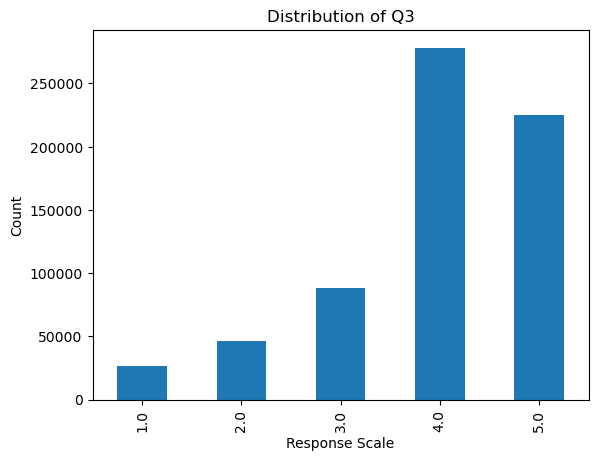

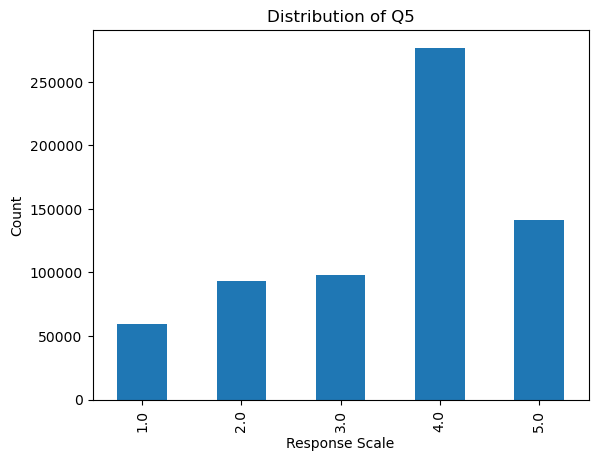

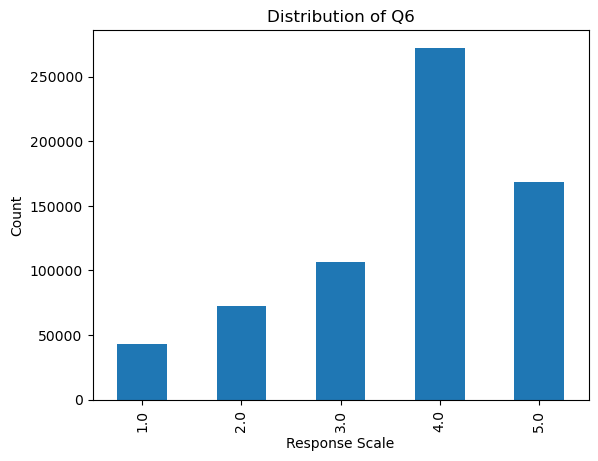

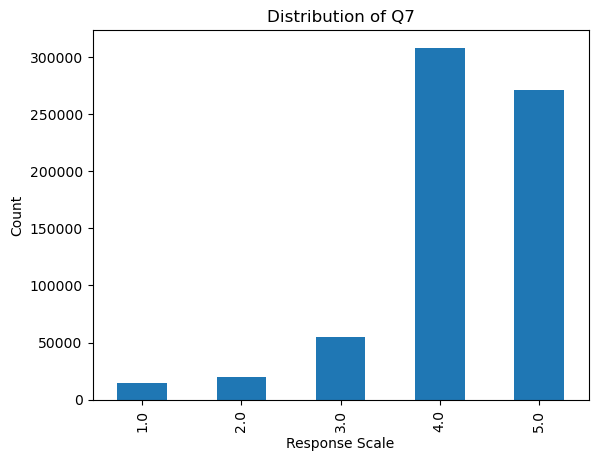

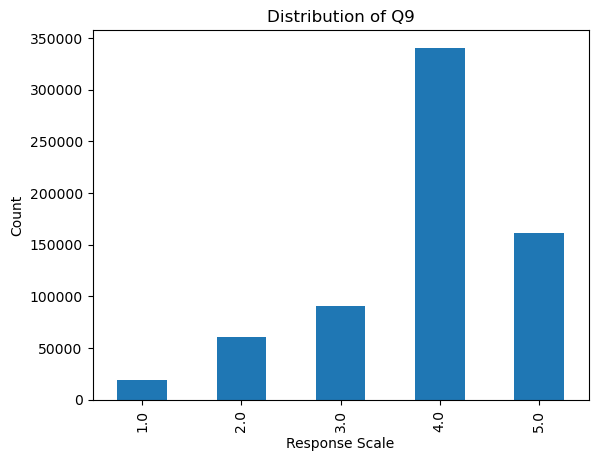

In [21]:
# Engagement & Workload Items

engagement_items = ["Q3", "Q5", "Q6", "Q7", "Q9"]

for col in engagement_items:
    plt.figure()
    df[col].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel("Response Scale")
    plt.ylabel("Count")
    plt.show()


### 4. Engagement Composite Score

A composite engagement score was created by averaging conceptually related Likert-scale items reflecting accomplishment, role clarity, information access, and alignment with organizational goals.

In [23]:
# Engagement Composite Score

df["engagement_score"] = df[["Q3", "Q6", "Q7", "Q9"]].mean(axis=1)

df["engagement_score"].describe()


count    674055.000000
mean          3.915217
std           0.843047
min           1.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: engagement_score, dtype: float64

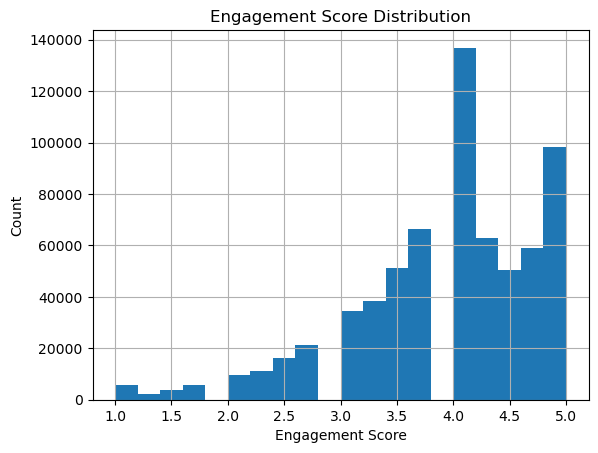

In [24]:
plt.figure()
df["engagement_score"].hist(bins=20)
plt.title("Engagement Score Distribution")
plt.xlabel("Engagement Score")
plt.ylabel("Count")
plt.show()


### 5. Engagement by Demographics

Engagement levels varied across tenure and supervisory groups, suggesting that role and career stage may influence employee sentiment and workplace experience.

<Figure size 640x480 with 0 Axes>

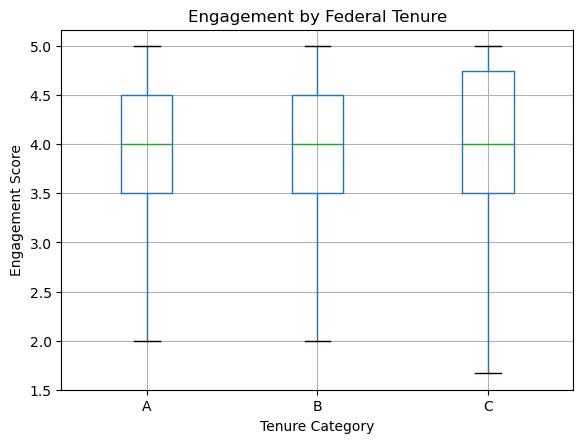

In [26]:
# By Tenure
plt.figure()
df.boxplot(column="engagement_score", by="DFEDTEN", showfliers=False)
plt.title("Engagement by Federal Tenure")
plt.suptitle("")
plt.xlabel("Tenure Category")
plt.ylabel("Engagement Score")
plt.show()


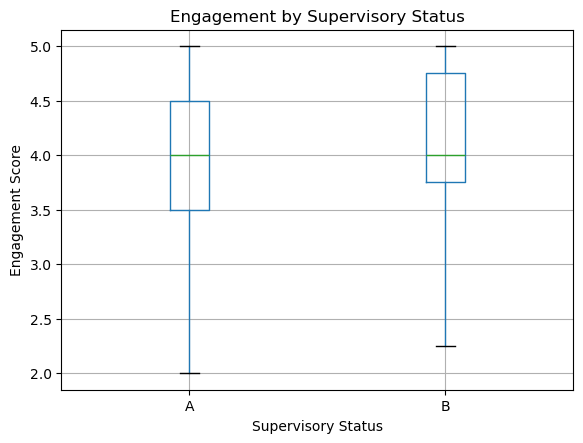

In [27]:
# Engagement By Supervisory Status

ax = df.boxplot(column="engagement_score", by="DSUPER", showfliers=False)
plt.title("Engagement by Supervisory Status")
plt.suptitle("")
plt.xlabel("Supervisory Status")
plt.ylabel("Engagement Score")
plt.show()



### 6. Relationship between engagement, workload, and intent to leave

Correlation analysis showed a moderate negative association between engagement and intent to leave, suggesting that employees with higher engagement scores tend to report lower likelihood of leaving.

In [29]:
# Numeric Converstion

leave_map = {
    "A": 1,
    "B": 2,
    "C": 3,
    "D": 4
}

df["DLEAVING_NUM"] = df["DLEAVING"].map(leave_map)


# Run Correlation

df[["engagement_score", "Q5", "DLEAVING_NUM"]].corr()


,engagement_score,Q5,DLEAVING_NUM
engagement_score,1.000000,0.510837,-0.358482
Q5,0.510837,1.000000,-0.254001
DLEAVING_NUM,-0.358482,-0.254001,1.000000


<Figure size 640x480 with 0 Axes>

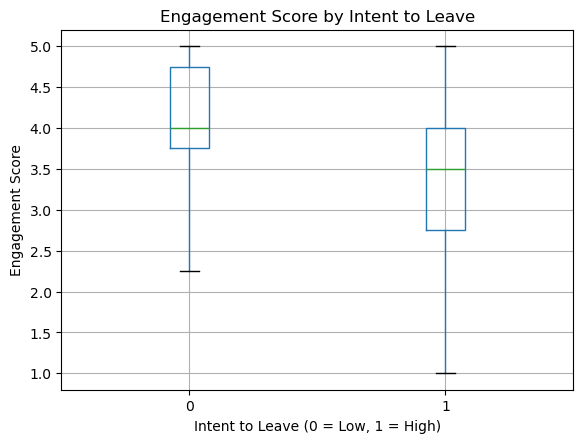

In [30]:
# Binary version (recommended for modeling + clearer interpretation)
df["intent_leave_flag"] = df["DLEAVING"].isin(["C", "D"]).astype(int)

# Compare engagement by intent group
df.groupby("intent_leave_flag")[["engagement_score", "Q5"]].mean()

# Optional: visualize difference in engagement by leave intent
plt.figure()
df.boxplot(column="engagement_score", by="intent_leave_flag", showfliers=False)
plt.title("Engagement Score by Intent to Leave")
plt.suptitle("")
plt.xlabel("Intent to Leave (0 = Low, 1 = High)")
plt.ylabel("Engagement Score")
plt.show()
